# Comparaison des Modèles Fine-tunés pour Question-Answering

**Cours:** M2 Datascale - Fouille de Données  
**Objectif:** Comparer les performances de plusieurs modèles fine-tunés sur SQuAD v1.1

Ce notebook charge les résultats sauvegardés par les différents modèles et génère :
- Tableaux comparatifs
- Visualisations
- Analyse des trade-offs
- Recommandations

## 1. Installation et Imports

In [10]:
!pip install -q matplotlib seaborn pandas tabulate

In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Style pour les graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 2. Configuration

**Modifiez cette section selon les modèles que vous avez entraînés**

In [4]:
# Répertoire contenant les modèles fine-tunés
MODELS_DIR = "../models"

# Liste des modèles à comparer (noms des dossiers)
MODEL_FOLDERS = [
    "distilbert_squad_finetuned",
    "roberta_squad_finetuned",
    "deberta_squad_finetuned",
]

# Noms courts pour l'affichage
MODEL_DISPLAY_NAMES = {
    "distilbert_squad_finetuned": "DistilBERT",
    "roberta_squad_finetuned": "RoBERTa",
    "deberta_squad_finetuned": "DeBERTa",
}

print(f"Recherche des modèles dans: {MODELS_DIR}")
print(f"Modèles à comparer: {len(MODEL_FOLDERS)}")

Recherche des modèles dans: ../models
Modèles à comparer: 3


## 3. Chargement des Résultats

In [5]:
def load_model_results(model_folder):
    """
    Charge les résultats d'un modèle depuis results.json
    """
    results_path = os.path.join(MODELS_DIR, model_folder, "results.json")

    if not os.path.exists(results_path):
        print(f"⚠️  Fichier non trouvé: {results_path}")
        return None

    try:
        with open(results_path, 'r') as f:
            data = json.load(f)
        print(f"✓ Chargé: {model_folder}")
        return data
    except Exception as e:
        print(f"❌ Erreur lors du chargement de {model_folder}: {e}")
        return None


# Charger tous les résultats
results_list = []

for model_folder in MODEL_FOLDERS:
    data = load_model_results(model_folder)
    if data:
        # Ajouter le nom d'affichage
        data['display_name'] = MODEL_DISPLAY_NAMES.get(model_folder, model_folder)
        results_list.append(data)

print(f"\nTotal: {len(results_list)} modèles chargés avec succès")

if len(results_list) == 0:
    print("\n⚠️ Aucun résultat trouvé. Vérifiez:")
    print(f"   1. Le chemin MODELS_DIR: {MODELS_DIR}")
    print(f"   2. Les noms dans MODEL_FOLDERS")
    print(f"   3. Que les fichiers results.json existent")

✓ Chargé: distilbert_squad_finetuned
✓ Chargé: roberta_squad_finetuned
✓ Chargé: deberta_squad_finetuned

Total: 3 modèles chargés avec succès


In [6]:
# Voir un exemple de résultats
if results_list:
    print("Exemple de données chargées:")
    print(json.dumps(results_list[0], indent=2))

Exemple de données chargées:
{
  "model_name": "distilbert-base-uncased",
  "model_type": "distilbert",
  "finetuned": true,
  "f1": 84.41070434105153,
  "exact_match": 75.80889309366131,
  "training_time_minutes": 55.61639648278554,
  "avg_inference_time_ms": 3.21042537689209,
  "total_parameters": 66364418,
  "trainable_parameters": 66364418,
  "num_train_samples": 87599,
  "num_eval_samples": 10570,
  "num_epochs": 3,
  "batch_size": 64,
  "learning_rate": 3e-05,
  "max_length": 384,
  "doc_stride": 128,
  "display_name": "DistilBERT"
}


## 4. Création du DataFrame de Comparaison

In [7]:
if results_list:
    # Créer le DataFrame
    comparison_data = []

    for result in results_list:
        comparison_data.append({
            'Modèle': result['display_name'],
            'Paramètres (M)': result['total_parameters'] / 1e6,
            'F1 (%)': result['f1'],
            'Exact Match (%)': result['exact_match'],
            'Temps Entraînement (min)': result['training_time_minutes'],
            'Inférence (ms)': result['avg_inference_time_ms'],
            'Échantillons Train': result['num_train_samples'],
            'Échantillons Eval': result['num_eval_samples'],
        })

    df = pd.DataFrame(comparison_data)

    # Trier par F1 décroissant
    df = df.sort_values('F1 (%)', ascending=False).reset_index(drop=True)

    print("DataFrame créé avec succès")
    print(f"Dimensions: {df.shape}")
else:
    print("Aucune donnée à afficher")

DataFrame créé avec succès
Dimensions: (3, 8)


## 5. Tableau Comparatif Principal

In [8]:
if results_list:
    print("="*80)
    print("TABLEAU COMPARATIF DES MODÈLES")
    print("="*80)

    # Afficher le tableau principal
    display_df = df[['Modèle', 'Paramètres (M)', 'F1 (%)', 'Exact Match (%)',
                     'Temps Entraînement (min)', 'Inférence (ms)']].copy()

    # Formater les nombres
    display_df['Paramètres (M)'] = display_df['Paramètres (M)'].apply(lambda x: f"{x:.1f}")
    display_df['F1 (%)'] = display_df['F1 (%)'].apply(lambda x: f"{x:.2f}")
    display_df['Exact Match (%)'] = display_df['Exact Match (%)'].apply(lambda x: f"{x:.2f}")
    display_df['Temps Entraînement (min)'] = display_df['Temps Entraînement (min)'].apply(lambda x: f"{x:.1f}")
    display_df['Inférence (ms)'] = display_df['Inférence (ms)'].apply(lambda x: f"{x:.1f}")

    print(display_df.to_string(index=False))
    print("="*80)

TABLEAU COMPARATIF DES MODÈLES
    Modèle Paramètres (M) F1 (%) Exact Match (%) Temps Entraînement (min) Inférence (ms)
   DeBERTa          183.8  93.01           86.58                    133.8           32.8
   RoBERTa          124.1  91.96           85.65                    101.9            7.5
DistilBERT           66.4  84.41           75.81                     55.6            3.2


In [11]:
# Générer le tableau au format Markdown (pour le rapport)
if results_list:
    print("\nTableau au format Markdown (copier pour le rapport):")
    print("="*80)
    print(display_df.to_markdown(index=False))
    print("="*80)


Tableau au format Markdown (copier pour le rapport):
| Modèle     |   Paramètres (M) |   F1 (%) |   Exact Match (%) |   Temps Entraînement (min) |   Inférence (ms) |
|:-----------|-----------------:|---------:|------------------:|---------------------------:|-----------------:|
| DeBERTa    |            183.8 |    93.01 |             86.58 |                      133.8 |             32.8 |
| RoBERTa    |            124.1 |    91.96 |             85.65 |                      101.9 |              7.5 |
| DistilBERT |             66.4 |    84.41 |             75.81 |                       55.6 |              3.2 |


## 6. Statistiques Descriptives

In [12]:
if results_list:
    print("Statistiques descriptives:\n")

    stats_df = df[['F1 (%)', 'Exact Match (%)', 'Temps Entraînement (min)', 'Inférence (ms)']]
    print(stats_df.describe().round(2))

    print("\nRésumé:")
    print(f"  Meilleur F1: {df.loc[0, 'Modèle']} ({df.loc[0, 'F1 (%)']:.2f}%)")
    print(f"  Meilleur EM: {df.loc[df['Exact Match (%)'].idxmax(), 'Modèle']} ({df['Exact Match (%)'].max():.2f}%)")
    print(f"  Plus rapide (entraînement): {df.loc[df['Temps Entraînement (min)'].idxmin(), 'Modèle']} ({df['Temps Entraînement (min)'].min():.1f} min)")
    print(f"  Plus rapide (inférence): {df.loc[df['Inférence (ms)'].idxmin(), 'Modèle']} ({df['Inférence (ms)'].min():.1f} ms)")

Statistiques descriptives:

       F1 (%)  Exact Match (%)  Temps Entraînement (min)  Inférence (ms)
count    3.00             3.00                      3.00            3.00
mean    89.80            82.68                     97.11           14.51
std      4.69             5.97                     39.31           15.96
min     84.41            75.81                     55.62            3.21
25%     88.19            80.73                     78.76            5.38
50%     91.96            85.65                    101.91            7.54
75%     92.49            86.11                    117.85           20.16
max     93.01            86.58                    133.79           32.77

Résumé:
  Meilleur F1: DeBERTa (93.01%)
  Meilleur EM: DeBERTa (86.58%)
  Plus rapide (entraînement): DistilBERT (55.6 min)
  Plus rapide (inférence): DistilBERT (3.2 ms)


## 7. Visualisations

### 7.1 Comparaison F1 et Exact Match

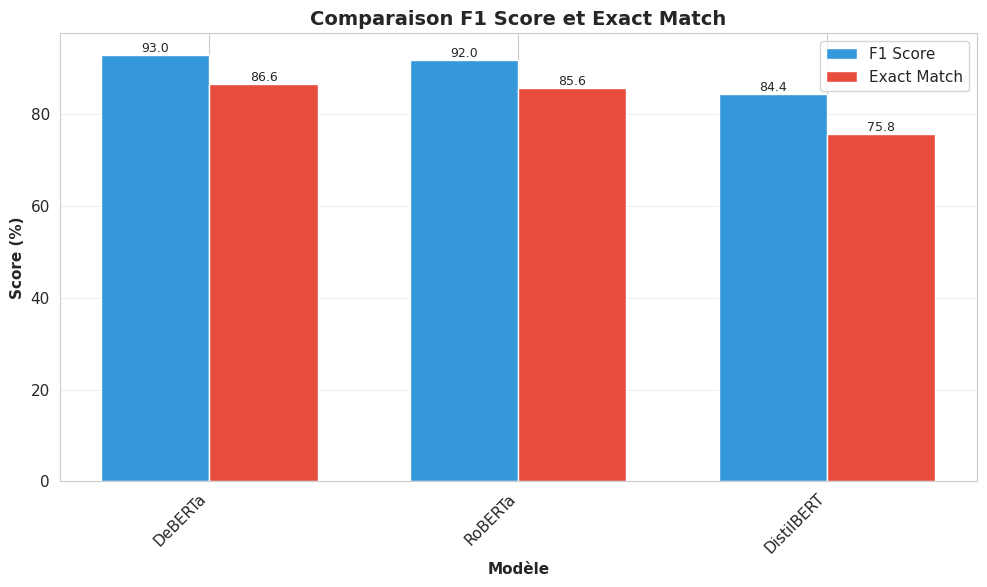

✓ Graphique sauvegardé: comparison_f1_em.png


In [13]:
if results_list:
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(df))
    width = 0.35

    bars1 = ax.bar(x - width/2, df['F1 (%)'], width, label='F1 Score', color='#3498db')
    bars2 = ax.bar(x + width/2, df['Exact Match (%)'], width, label='Exact Match', color='#e74c3c')

    ax.set_xlabel('Modèle', fontweight='bold')
    ax.set_ylabel('Score (%)', fontweight='bold')
    ax.set_title('Comparaison F1 Score et Exact Match', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Modèle'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Ajouter les valeurs sur les barres
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig('comparison_f1_em.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Graphique sauvegardé: comparison_f1_em.png")

### 7.2 Trade-off Performance vs Vitesse

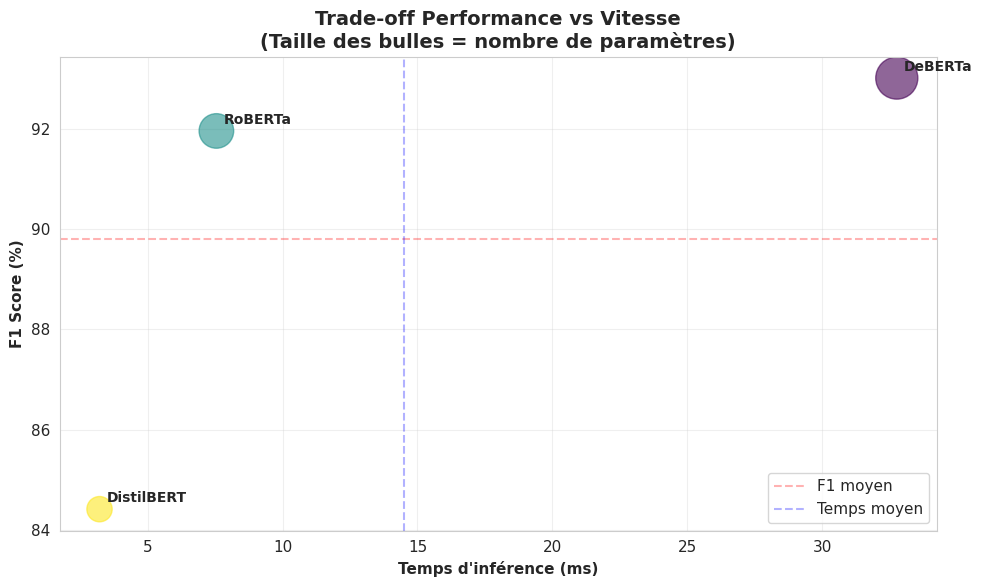

✓ Graphique sauvegardé: tradeoff_performance_speed.png


In [14]:
if results_list:
    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter plot avec taille = nombre de paramètres
    scatter = ax.scatter(df['Inférence (ms)'], df['F1 (%)'],
                        s=df['Paramètres (M)']*5,  # Taille proportionnelle aux params
                        alpha=0.6, c=range(len(df)), cmap='viridis')

    # Ajouter les labels
    for idx, row in df.iterrows():
        ax.annotate(row['Modèle'],
                   (row['Inférence (ms)'], row['F1 (%)']),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=10, fontweight='bold')

    ax.set_xlabel('Temps d\'inférence (ms)', fontweight='bold')
    ax.set_ylabel('F1 Score (%)', fontweight='bold')
    ax.set_title('Trade-off Performance vs Vitesse\n(Taille des bulles = nombre de paramètres)',
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Zones idéales
    ax.axhline(y=df['F1 (%)'].mean(), color='red', linestyle='--', alpha=0.3, label='F1 moyen')
    ax.axvline(x=df['Inférence (ms)'].mean(), color='blue', linestyle='--', alpha=0.3, label='Temps moyen')
    ax.legend()

    plt.tight_layout()
    plt.savefig('tradeoff_performance_speed.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Graphique sauvegardé: tradeoff_performance_speed.png")

### 7.3 Temps d'Entraînement vs Paramètres

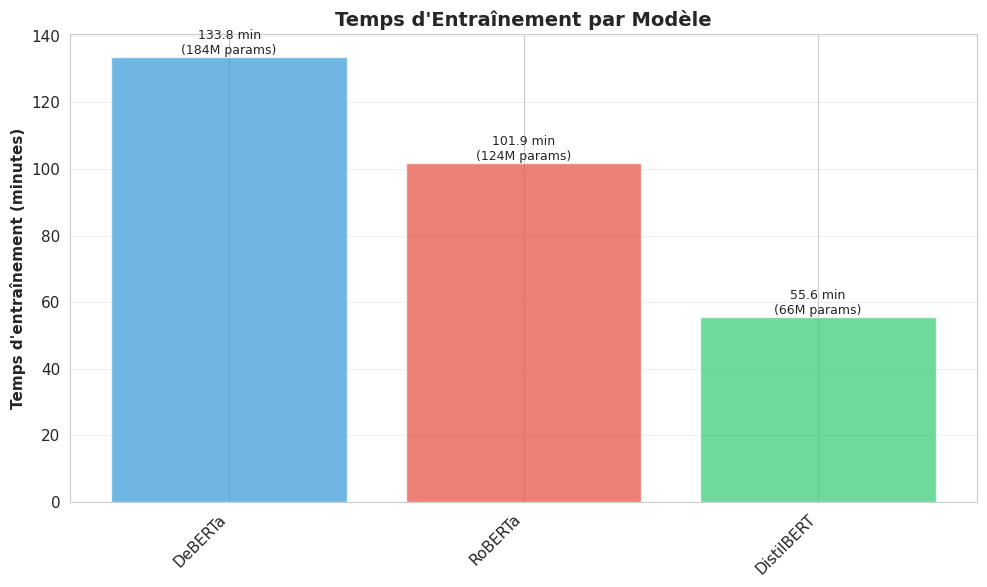

✓ Graphique sauvegardé: training_time_comparison.png


In [15]:
if results_list:
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    bars = ax.bar(df['Modèle'], df['Temps Entraînement (min)'],
                  color=colors[:len(df)], alpha=0.7)

    ax.set_ylabel('Temps d\'entraînement (minutes)', fontweight='bold')
    ax.set_title('Temps d\'Entraînement par Modèle', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Ajouter les valeurs et nombre de paramètres
    for idx, (bar, row) in enumerate(zip(bars, df.itertuples())):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f} min\n({row._2:.0f}M params)',
               ha='center', va='bottom', fontsize=9)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('training_time_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Graphique sauvegardé: training_time_comparison.png")

### 7.4 Heatmap des Métriques Normalisées

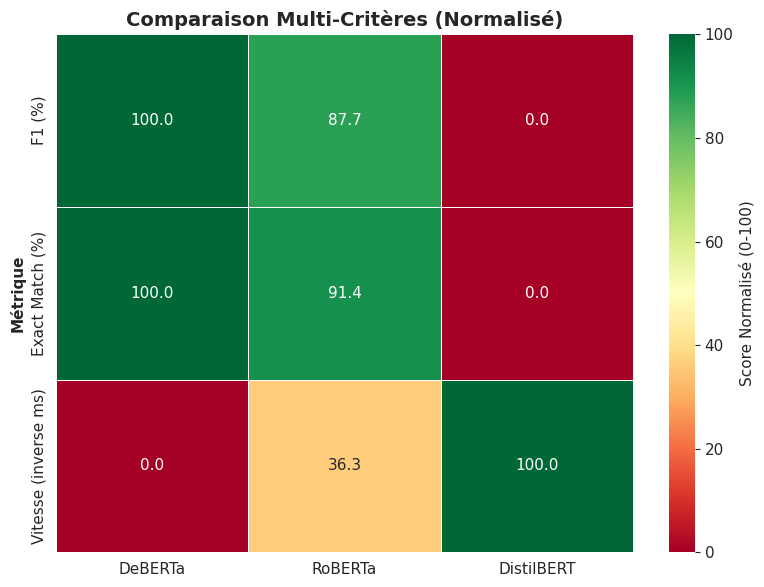

✓ Graphique sauvegardé: heatmap_normalized.png


In [16]:
if results_list and len(df) > 1:
    # Préparer les données pour la heatmap
    heatmap_data = df[['Modèle', 'F1 (%)', 'Exact Match (%)', 'Inférence (ms)']].copy()
    heatmap_data = heatmap_data.set_index('Modèle')

    # Inverser le temps d'inférence (plus bas = mieux)
    heatmap_data['Vitesse (inverse ms)'] = 1 / heatmap_data['Inférence (ms)'] * 100
    heatmap_data = heatmap_data.drop('Inférence (ms)', axis=1)

    # Normaliser entre 0 et 100
    normalized = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min()) * 100

    fig, ax = plt.subplots(figsize=(8, 6))

    sns.heatmap(normalized.T, annot=True, fmt='.1f', cmap='RdYlGn',
                cbar_kws={'label': 'Score Normalisé (0-100)'},
                linewidths=0.5, ax=ax)

    ax.set_title('Comparaison Multi-Critères (Normalisé)', fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Métrique', fontweight='bold')

    plt.tight_layout()
    plt.savefig('heatmap_normalized.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Graphique sauvegardé: heatmap_normalized.png")

## 8. Analyse des Résultats

In [17]:
if results_list:
    print("="*80)
    print("ANALYSE DES RÉSULTATS")
    print("="*80)

    # 1. Meilleur modèle global (F1)
    best_f1 = df.loc[0]
    print(f"\n1. MEILLEUR F1 SCORE: {best_f1['Modèle']}")
    print(f"   - F1: {best_f1['F1 (%)']:.2f}%")
    print(f"   - Exact Match: {best_f1['Exact Match (%)']:.2f}%")
    print(f"   - Paramètres: {best_f1['Paramètres (M)']:.1f}M")

    # 2. Modèle le plus rapide
    fastest = df.loc[df['Inférence (ms)'].idxmin()]
    print(f"\n2. PLUS RAPIDE (INFÉRENCE): {fastest['Modèle']}")
    print(f"   - Temps: {fastest['Inférence (ms)']:.1f} ms")
    print(f"   - F1: {fastest['F1 (%)']:.2f}%")
    print(f"   - Trade-off: {fastest['F1 (%)'] / fastest['Inférence (ms)']:.2f} F1/ms")

    # 3. Meilleur rapport qualité/vitesse
    df['Efficacité'] = df['F1 (%)'] / df['Inférence (ms)']
    most_efficient = df.loc[df['Efficacité'].idxmax()]
    print(f"\n3. MEILLEUR RAPPORT QUALITÉ/VITESSE: {most_efficient['Modèle']}")
    print(f"   - Efficacité: {most_efficient['Efficacité']:.2f} F1/ms")
    print(f"   - F1: {most_efficient['F1 (%)']:.2f}%")
    print(f"   - Inférence: {most_efficient['Inférence (ms)']:.1f} ms")

    # 4. Différences de performance
    if len(df) > 1:
        f1_gap = df['F1 (%)'].max() - df['F1 (%)'].min()
        em_gap = df['Exact Match (%)'].max() - df['Exact Match (%)'].min()
        speed_gap = df['Inférence (ms)'].max() - df['Inférence (ms)'].min()

        print(f"\n4. ÉCARTS OBSERVÉS:")
        print(f"   - F1: {f1_gap:.2f} points ({f1_gap/df['F1 (%)'].mean()*100:.1f}%)")
        print(f"   - Exact Match: {em_gap:.2f} points ({em_gap/df['Exact Match (%)'].mean()*100:.1f}%)")
        print(f"   - Vitesse: {speed_gap:.1f} ms ({speed_gap/df['Inférence (ms)'].mean()*100:.1f}%)")

    print("\n" + "="*80)

ANALYSE DES RÉSULTATS

1. MEILLEUR F1 SCORE: DeBERTa
   - F1: 93.01%
   - Exact Match: 86.58%
   - Paramètres: 183.8M

2. PLUS RAPIDE (INFÉRENCE): DistilBERT
   - Temps: 3.2 ms
   - F1: 84.41%
   - Trade-off: 26.29 F1/ms

3. MEILLEUR RAPPORT QUALITÉ/VITESSE: DistilBERT
   - Efficacité: 26.29 F1/ms
   - F1: 84.41%
   - Inférence: 3.2 ms

4. ÉCARTS OBSERVÉS:
   - F1: 8.60 points (9.6%)
   - Exact Match: 10.77 points (13.0%)
   - Vitesse: 29.6 ms (203.8%)



## 9. Recommandations

In [18]:
if results_list:
    print("="*80)
    print("RECOMMANDATIONS")
    print("="*80)

    print("\nSelon le cas d'usage:\n")

    # Cas 1: Performance maximale
    best_perf = df.loc[0]
    print(f"📊 PERFORMANCE MAXIMALE:")
    print(f"   → {best_perf['Modèle']}")
    print(f"   Raison: Meilleur F1 ({best_perf['F1 (%)']:.2f}%)")
    print(f"   Compromis: {best_perf['Inférence (ms)']:.1f} ms d'inférence\n")

    # Cas 2: Latence minimale
    fastest = df.loc[df['Inférence (ms)'].idxmin()]
    print(f"⚡ TEMPS RÉEL / LATENCE MINIMALE:")
    print(f"   → {fastest['Modèle']}")
    print(f"   Raison: Plus rapide ({fastest['Inférence (ms)']:.1f} ms)")
    print(f"   Compromis: F1 de {fastest['F1 (%)']:.2f}% (vs {best_perf['F1 (%)']:.2f}% max)\n")

    # Cas 3: Équilibre
    balanced = df.loc[df['Efficacité'].idxmax()]
    print(f"⚖️  ÉQUILIBRE PERFORMANCE/VITESSE:")
    print(f"   → {balanced['Modèle']}")
    print(f"   Raison: Meilleur ratio qualité/vitesse ({balanced['Efficacité']:.2f} F1/ms)")
    print(f"   Avantages: F1={balanced['F1 (%)']:.2f}%, Temps={balanced['Inférence (ms)']:.1f}ms\n")

    # Cas 4: Ressources limitées
    lightest = df.loc[df['Paramètres (M)'].idxmin()]
    print(f"💾 RESSOURCES LIMITÉES (Mobile/Edge):")
    print(f"   → {lightest['Modèle']}")
    print(f"   Raison: Moins de paramètres ({lightest['Paramètres (M)']:.1f}M)")
    print(f"   Performance: F1={lightest['F1 (%)']:.2f}%")

    print("\n" + "="*80)

RECOMMANDATIONS

Selon le cas d'usage:

📊 PERFORMANCE MAXIMALE:
   → DeBERTa
   Raison: Meilleur F1 (93.01%)
   Compromis: 32.8 ms d'inférence

⚡ TEMPS RÉEL / LATENCE MINIMALE:
   → DistilBERT
   Raison: Plus rapide (3.2 ms)
   Compromis: F1 de 84.41% (vs 93.01% max)

⚖️  ÉQUILIBRE PERFORMANCE/VITESSE:
   → DistilBERT
   Raison: Meilleur ratio qualité/vitesse (26.29 F1/ms)
   Avantages: F1=84.41%, Temps=3.2ms

💾 RESSOURCES LIMITÉES (Mobile/Edge):
   → DistilBERT
   Raison: Moins de paramètres (66.4M)
   Performance: F1=84.41%



## 10. Export des Résultats

In [19]:
if results_list:
    # Sauvegarder le DataFrame en CSV
    csv_path = "comparison_results.csv"
    df.to_csv(csv_path, index=False)
    print(f"✓ Tableau sauvegardé: {csv_path}")

    # Sauvegarder en Excel
    try:
        excel_path = "comparison_results.xlsx"
        df.to_excel(excel_path, index=False, sheet_name="Comparaison")
        print(f"✓ Tableau sauvegardé: {excel_path}")
    except:
        print("⚠️  Excel non disponible (pip install openpyxl pour activer)")

    # Sauvegarder un rapport JSON complet
    report = {
        "date_comparison": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        "num_models": len(results_list),
        "models_compared": [r['model_name'] for r in results_list],
        "best_f1": {
            "model": best_f1['Modèle'],
            "score": float(best_f1['F1 (%)'])
        },
        "fastest": {
            "model": fastest['Modèle'],
            "inference_time_ms": float(fastest['Inférence (ms)'])
        },
        "most_efficient": {
            "model": balanced['Modèle'],
            "efficiency": float(balanced['Efficacité'])
        },
        "detailed_results": results_list
    }

    json_path = "comparison_report.json"
    with open(json_path, 'w') as f:
        json.dump(report, f, indent=2)
    print(f"✓ Rapport complet: {json_path}")

    print("\nFichiers générés:")
    print("  - comparison_results.csv")
    print("  - comparison_results.xlsx (si disponible)")
    print("  - comparison_report.json")
    print("  - comparison_f1_em.png")
    print("  - tradeoff_performance_speed.png")
    print("  - training_time_comparison.png")
    print("  - heatmap_normalized.png")

✓ Tableau sauvegardé: comparison_results.csv
⚠️  Excel non disponible (pip install openpyxl pour activer)
✓ Rapport complet: comparison_report.json

Fichiers générés:
  - comparison_results.csv
  - comparison_results.xlsx (si disponible)
  - comparison_report.json
  - comparison_f1_em.png
  - tradeoff_performance_speed.png
  - training_time_comparison.png
  - heatmap_normalized.png
